In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from pathlib import Path
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt
import itertools


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import CVATDataset, DataHelper
from dataset import worker_init_fn, variable_shape_collate_fn
import transforms
from transforms import BoundingBoxFormatConvert,ToX1y1x2y2Abs, ToCxcywhRel, ToIaa, iaa_hsv_aug, iaa_random_crop, iaa_letterbox, \
                       IaaAugmentations, ToNp, IaaLetterbox, ToTensor, Compose
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter
from imgaug import augmenters as iaa
from utils import postprocessing, letterbox_transforms, letterbox_label_reverse
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *



In [2]:
seed = 0

def set_seed(seed):
    cudnn.benchmark = False
    cudnn.deterministic = True

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(seed)

# Paths

In [3]:
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'

In [4]:
cv2.setNumThreads(0)

# Training

## Set up dataloader

In [5]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

In [7]:
def getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
                subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=None,
                max_net_batches=None, net_subdivisions=1):
    torch.manual_seed(seed)
    cvat_trans_fn = get_trans_fn(np.arange(1,5), CoordinateType.Relative, FormatType.cxcywh, aug)
    cvat_ds = CVATDataset(cvat_img_dir, label_xml_path, bs, subset_idx=subset_idx, trans_fn=cvat_trans_fn,
                          shuffle=shuffle, cyclic=cyclic, dim=dim, rand_dim_interval=rand_dim_interval)
    cvat_dl = DataLoader(cvat_ds, batch_size=bs, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn, collate_fn=variable_shape_collate_fn)
    cvat_data = DataHelper(cvat_ds, cvat_dl, current_batch=0, max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    return cvat_data

In [8]:
def get_trans_fn(bbs_idx, coord_type, format_type, aug):
    def getTransformByDim(dim):
        return getTransforms(dim, bbs_idx, coord_type, format_type, aug)
    return getTransformByDim

## Initial training

In [9]:
seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.0001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 80 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 20 #100
# Maximum net batches to train
max_net_batches = 1000# 500200

In [ ]:
model_id = 'x_wing_rand_7'
weight_dir = './weights'

#remove_checkpoints(model_id, weight_dir)

set_seed(seed)
net = YoloNet((sz, sz), numClass=2).cuda()
net.feature.loadWeight(backbone_weight_path)

data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
                   subset_idx=None, shuffle=True, cyclic=True, dim=dim, rand_dim_interval=random_dim_interval,
                   max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
recorder = Recorder()


train(data, net, optimizer, recorder,
      model_id=model_id, weight_dir=weight_dir,
      checkpoint=None, checkpoint_interval=checkpoint_interval,
      use_gpu=True) 

## Resume training (make sure 'model_id' matches)

In [8]:
def resume_training(max_net_batches, model_id, weight_dir):
    checkpoint_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    #pt_weight_path = './weights/x_wing_rand_1/yolov3_x_wing_rand_1_checkpoint_0159.pth.tar'
    if checkpoint_path is None:
        print('No checkpoint for %s found' % model_id)
        return

    print('Loading %s' % checkpoint_path)
    checkpoint = load_checkpoint(checkpoint_path)

    data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=True,
               subset_idx=None, shuffle=True, cyclic=True, dim=None, rand_dim_interval=random_dim_interval,
               max_net_batches=max_net_batches, net_subdivisions=net_subdivisions)
    net = YoloNet((sz, sz), numClass=2).cuda()
    optimizer = get_optimizer(net, lr, backbone_lr, wd, momentum, freeze_backbone)
    recorder = Recorder()

    train(data, net, optimizer, recorder,
          model_id=model_id, weight_dir=weight_dir,
          checkpoint=checkpoint, checkpoint_interval=checkpoint_interval,
          use_gpu=True) 


In [9]:
seed = 0
sz = 416
dim = (sz, sz)
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
backbone_lr = 0.001 / ratio
momentum = 0.9
wd = 0.0005
freeze_backbone = False
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 8
bs = int(net_bs / net_subdivisions)
# Change image dimension every 10 net_batch -> 40 mini-batch
random_dim_interval = net_bs * 10
# Save interval in units of net batch
checkpoint_interval = 20 #100
# Maximum net batches to train
max_net_batches = 1000# 500200

In [ ]:
model_id = 'x_wing_rand_7'
weight_dir = './weights'

set_seed(seed)
resume_training(max_net_batches, model_id, weight_dir)

## Test model on images

## Drawing functions

In [11]:
def draw_axis(ax, isDraw=False):
    ax.get_xaxis().set_visible(isDraw)
    ax.get_yaxis().set_visible(isDraw)

def draw_image(ax, img):
    ax.imshow(img)

def draw_labels(ax, labels, classes, coord_idx=[1,2,3,4], class_idx=0):
    for l in labels:
        if l.sum() == 0:
            continue
        rect = l[coord_idx]
        c = classes[l[class_idx].astype(np.int32)]
        draw_rect(ax, rect)
        draw_text(ax, rect[:2], c)
        

# Display a list of images with labels in given grid size         
def show_img_grid(img_list, classes=None,
                  labels_list=None, coord_idx=[1,2,3,4], class_idx=0,
                  cols=2, figsize=None):
    rows = int(np.ceil(len(img_list) / cols))

    heights = [a.shape[0] for a in img_list[::cols]]
    widths = [a.shape[1] for a in img_list[0:cols]]

    fig_width = 25  # inches
    fig_height = fig_width * sum(heights) / sum(widths)
    fig_size = (fig_width, fig_height)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size, gridspec_kw={'height_ratios':heights})
    axes = [ax for ax in axes.ravel()]
    
    for ax, img, labels in itertools.zip_longest(axes, img_list, labels_list, fillvalue=None):
        if img is not None:
            draw_image(ax, img)
        if labels is not None:
            draw_labels(ax, labels, classes, coord_idx=coord_idx, class_idx=class_idx)
        draw_axis(ax, False)
        
    plt.subplots_adjust(wspace=0.01, hspace=0.02, left=0, right=1, bottom=0, top=1)
    #plt.tight_layout()

## Helper functions

In [12]:
def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None and len(label) != 0 :
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp

def letterbox_reverse_exp(labels, params):
    for i, (l, p) in enumerate(zip(labels, params)):
        org_img, padded_dim = tuple(p[0:2]), tuple(p[2:4])
        x_pad, y_pad = p[4], p[5]
        labels[i] = transforms.letterbox_reverter(l, org_img, padded_dim, x_pad, y_pad, np.array([0,1,2,3]))
    return labels

def prep_img_for_plt(img_list):
    img_list = img_list.permute(0,2,3,1).numpy()
    return img_list
      
def prep_predictions_for_plt(preds_list, dim):
    preds_list = np.asarray([fill_label_np_tensor(p.numpy(), 50, 7) for p in preds_list])
    preds_list = preds_list[..., [6, 0, 1, 2, 3,]]
    preds_list = BoundingBoxConverter.convert(preds_list, CoordinateType.Absolute, FormatType.x1y1x2y2,
                                                      CoordinateType.Absolute, FormatType.xywh,
                                                      np.array([1,2,3,4]), dim)
    return preds_list

def prep_img_for_opencv(img_list):
    img_list = img_list.permute(0,2,3,1) * 255
    img_list = img_list.numpy().astype(np.uint8)
    return img_list


## Parameters

In [13]:
seed = 0
sz = 416
dim = (sz, sz)
bs = 8

weight_dir = './weights'

model_id = 'x_wing_rand_7'
weight_dir = './weights'
output_dir = './output/' + model_id
output_img_dir = output_dir + '/img'
output_label_dir = output_dir + '/label'

## Run the model and show the detections on images

In [14]:
def predict(data, net, reverse_letterbox=True):
    img_list = torch.FloatTensor()
    preds_list = []
    with torch.no_grad(): 
        for sample in data:
            org_imgs = sample['org_img']
            imgs = sample['img'].cuda()
            dim = (imgs.shape[3], imgs.shape[2])
            
            # Pass images to the network
            det1, det2, det3 = net(imgs.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 2, obj_conf_thr=0.5, nms_thr=0.4)
            

            # Letterbox transform reverse the predictions coordinates 
            if reverse_letterbox:                      
                img_list = torch.cat((img_list, org_imgs.cpu()))
                preds_list += letterbox_reverse_exp(predictions, sample['lb_reverter'])
            else:
                img_list = torch.cat((img_list, imgs.cpu()))
                preds_list += predictions
                
            print('Batch:{} {}'.format(data.current_batch, str(sample['img'].shape)))
            
        img_list = prep_img_for_plt(img_list)
        preds_list = prep_predictions_for_plt(preds_list, dim)
    return img_list, preds_list


def show_detections(data, net, reverse_letterbox=True, use_gpu=True):
    img_list, preds_list = predict(data, net, reverse_letterbox=reverse_letterbox)
    show_img_grid(img_list, cols=2, classes=classes_names, labels_list=preds_list)

Batch:0 torch.Size([8, 3, 416, 416])
Batch:1 torch.Size([4, 3, 416, 416])


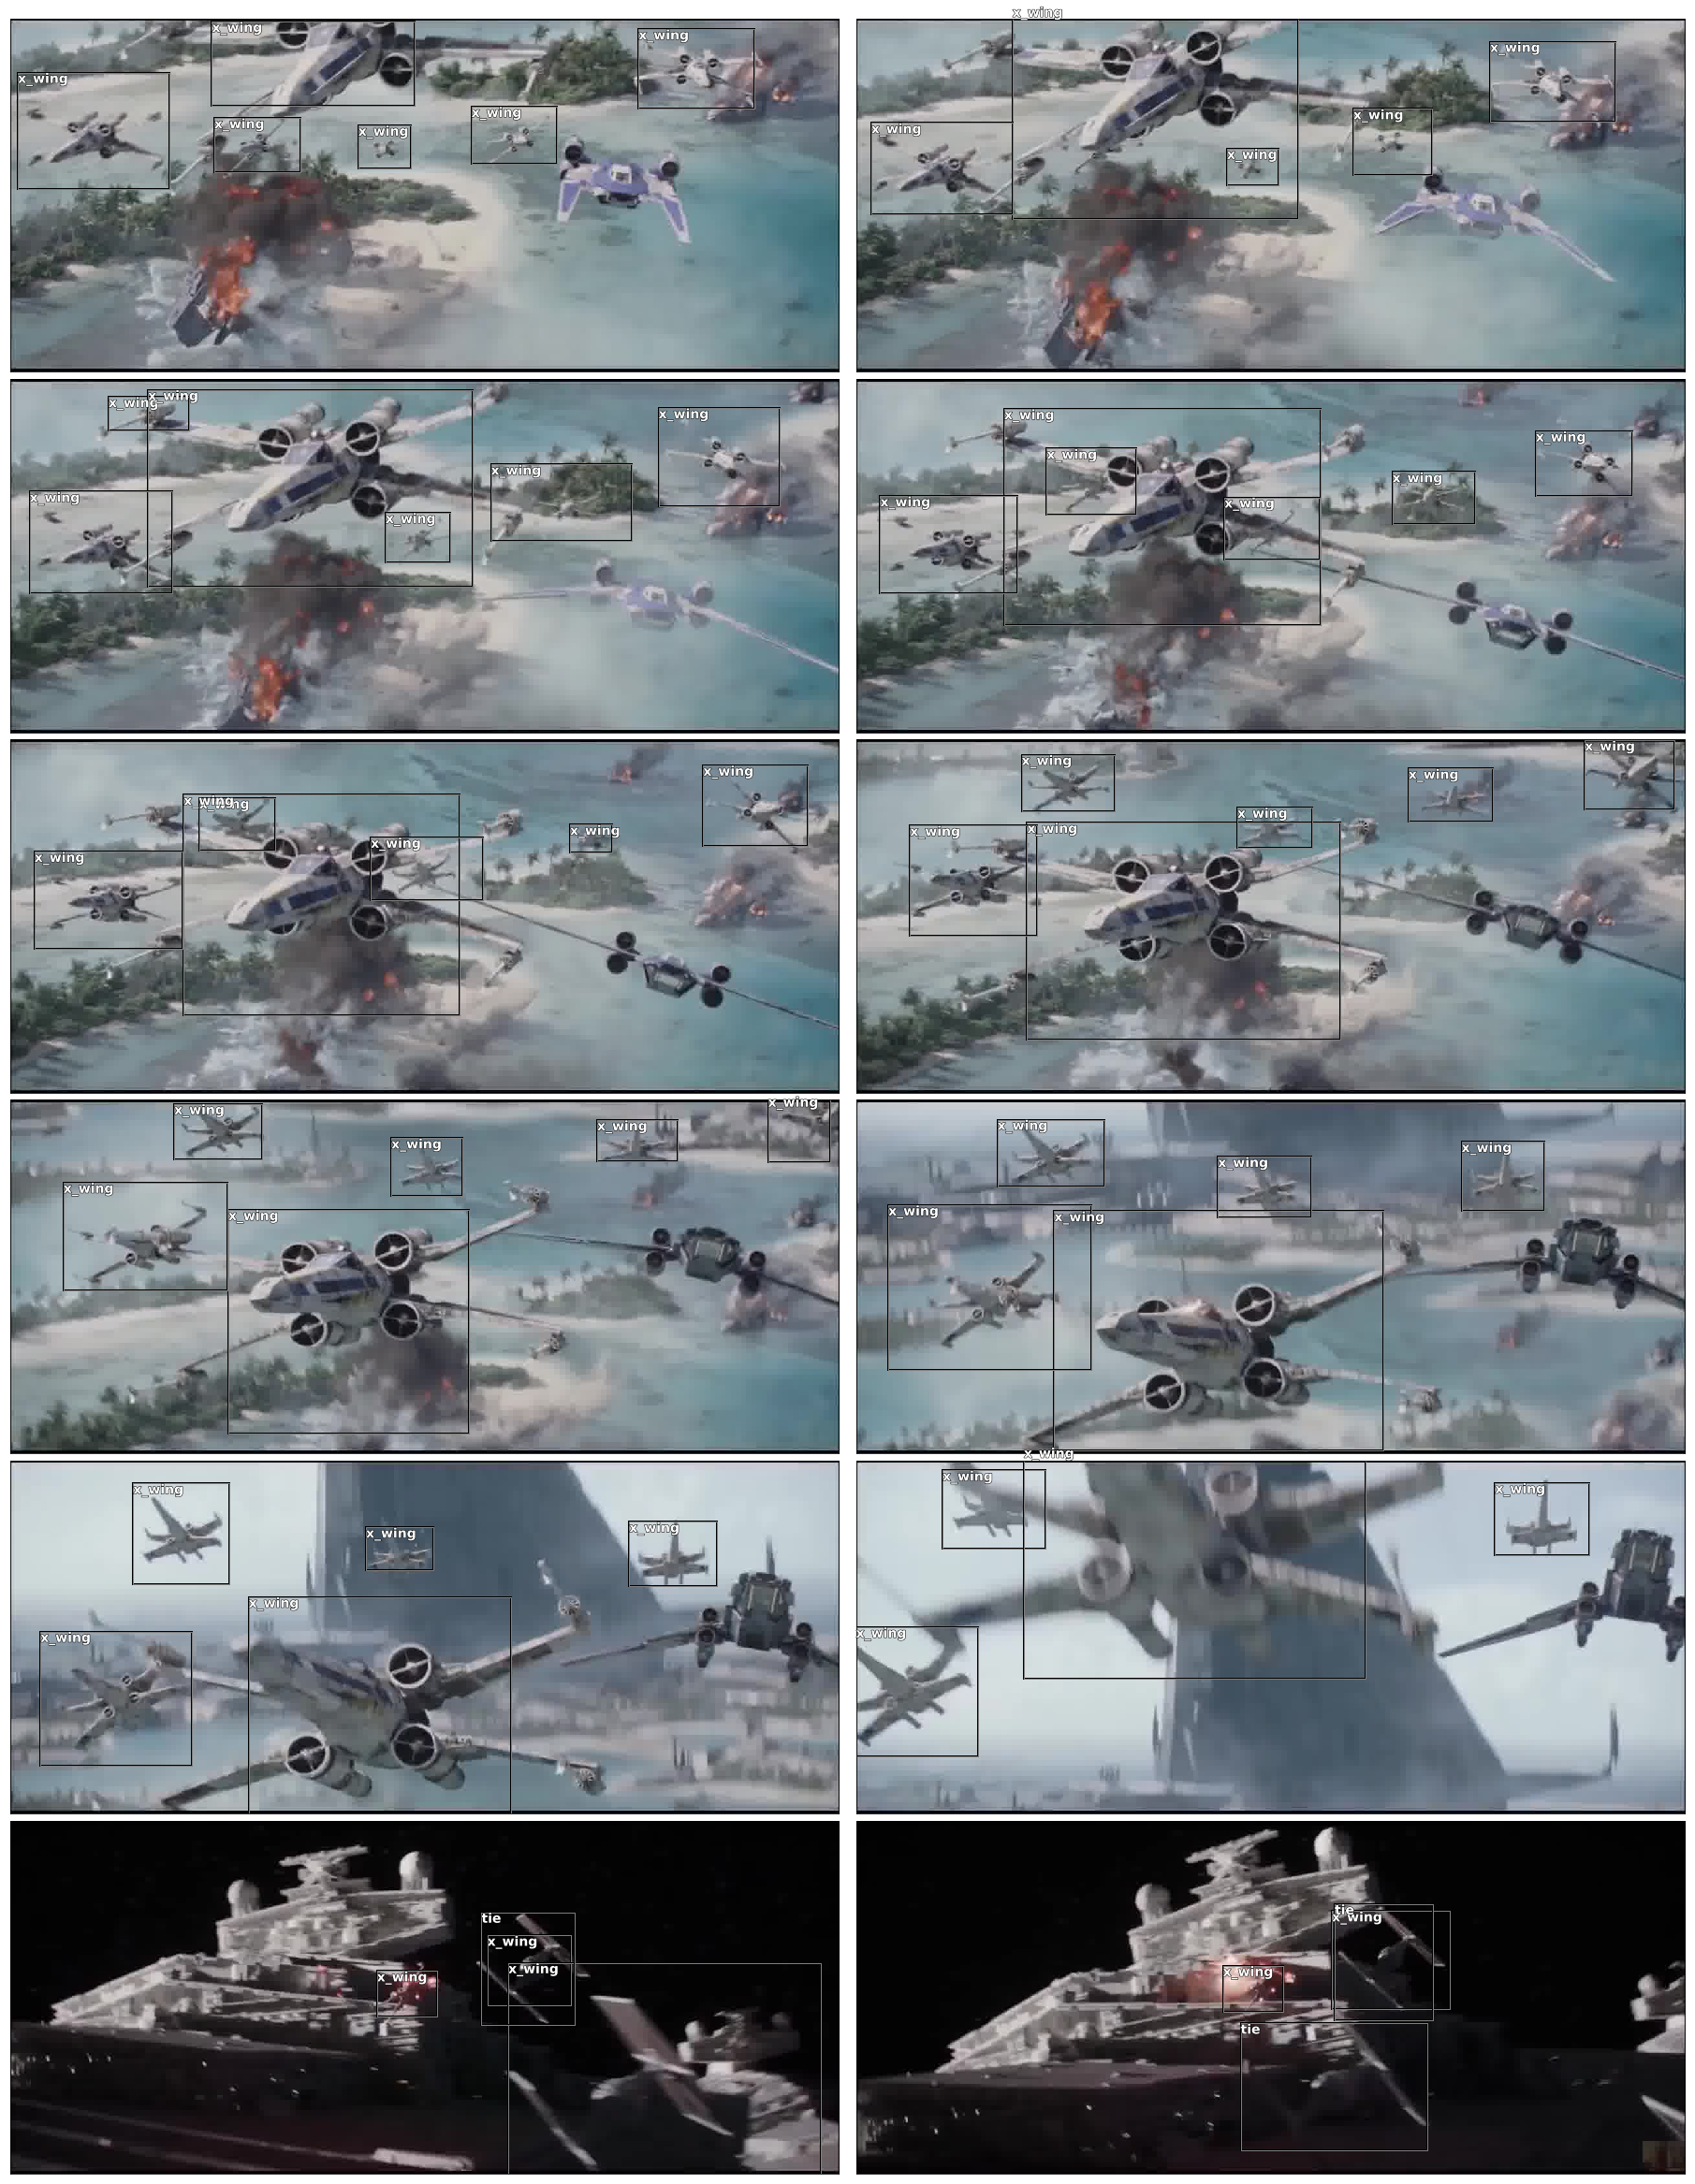

In [26]:
# Display subset of the training set
start = 200
subset_idx = np.arange(start, start + 12)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])
data = getCVATData(4, cvat_img_dir, label_xml_path, bs, aug=False,
                   subset_idx=subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                   max_net_batches=None, net_subdivisions=1)
net = YoloNet(dim, numClass=2).cuda().eval()
net.load_state_dict(checkpoint['net'])

show_detections(data, net)

## Save detections to images and text file

In [27]:
def save_detections(save_path, labels, inp_fmt="x1 y1 x2 y2 conf cls clsId", out_fmt="clsId conf x1 y1 x2 y2"):
    if len(labels) == 0:
        return

    inp_dict = {v:i for i,v in enumerate(inp_fmt.split(' '))}
    out_list = out_fmt.split(' ')
    out_idx = [inp_dict[i] for i in out_list]
    out = labels[..., out_idx]
    fmt = []
    for o in out_list:
        if o == 'clsId':
            fmt.append('%d')
        else:
            fmt.append('%.6f')
    fmt = ' '.join(fmt)
    np.savetxt(save_path, out, fmt)


def opencv_draw_predictions(img, labels, classes_names, bbox_colors, font_scale=2.0, font=cv2.LINE_AA, line_width=4):
    img_w, img_h = img.shape[1], img.shape[0]
    for l in labels:
        box_coord = l[0:4]
        cls = l[6].int().item()

        cls_text = classes_names[cls]
        cls_color = bbox_colors[cls % 20].int().tolist()

        pt1 = tuple(box_coord[0:2].int().numpy())
        pt2 = tuple(box_coord[2:4].int().numpy())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
    return img

def predict_and_save(data, net, classes_names, output_img_dir=None, output_label_dir=None, reverse_letterbox=True, save_labels=True, save_imgs=True):
    bbox_colors = get_color_pallete(20) * 255
    
    with torch.no_grad(): 
        for sample in data:
            org_imgs, img_paths = sample['org_img'], sample['img_path']
            imgs = sample['img'].cuda()
            dim = (imgs.shape[3], imgs.shape[2])
            
            # Pass images to the network
            det1, det2, det3 = net(imgs.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 2, obj_conf_thr=0.5, nms_thr=0.4)

            # Letterbox transform reverse the predictions coordinates 
            if reverse_letterbox:                      
                predictions = letterbox_reverse_exp(predictions, sample['lb_reverter'])
                out_imgs = org_imgs
            
            out_imgs = prep_img_for_opencv(out_imgs)
            
            for out_img, prediction, img_path in zip(out_imgs, predictions, img_paths):
                out_img = opencv_draw_predictions(out_img, prediction, classes_names, bbox_colors)
                
                img_name = Path(img_path).stem
                if save_imgs:
                    os.makedirs(output_img_dir, exist_ok=True)
                    cv2.imwrite(osp.join(output_img_dir, img_name + '.jpg'), out_img)
                if save_labels:
                    os.makedirs(output_label_dir, exist_ok=True)
                    save_detections(osp.join(output_label_dir, img_name + '.txt'), prediction)

In [28]:
# Select subset of the training set
start = 200
subset_idx = np.arange(start, start + 12)

            
data = getCVATData(seed, cvat_img_dir, label_xml_path, bs, aug=False,
                   subset_idx=subset_idx, shuffle=False, cyclic=False, dim=dim, rand_dim_interval=None,
                   max_net_batches=None, net_subdivisions=1)

checkpoint = load_checkpoint(get_latest_checkpoint(model_id, weight_dir)[0])

net = YoloNet(dim, numClass=2).cuda().eval()
net.load_state_dict(checkpoint['net'])

predict_and_save(data, net, classes_names, output_img_dir=output_img_dir, output_label_dir=output_label_dir)

In [29]:
def read_detections(img_dets_dir, idx=0, bs=4):
    img_dets_list = sorted([osp.join(img_dets_dir, f) for f in os.listdir(img_dets_dir)])
    for i in range(idx, idx + bs):
        if i >= len(img_dets_list) - 1:
            break
        img_path = img_dets_list[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        show_img(img, figsize=(16,8))
        print(img_path)

./output/x_wing_rand_7/img/x_wing_0379.jpg
./output/x_wing_rand_7/img/x_wing_0380.jpg
./output/x_wing_rand_7/img/x_wing_0381.jpg
./output/x_wing_rand_7/img/x_wing_0382.jpg
./output/x_wing_rand_7/img/x_wing_0383.jpg
./output/x_wing_rand_7/img/x_wing_0384.jpg
./output/x_wing_rand_7/img/x_wing_0385.jpg
./output/x_wing_rand_7/img/x_wing_0386.jpg


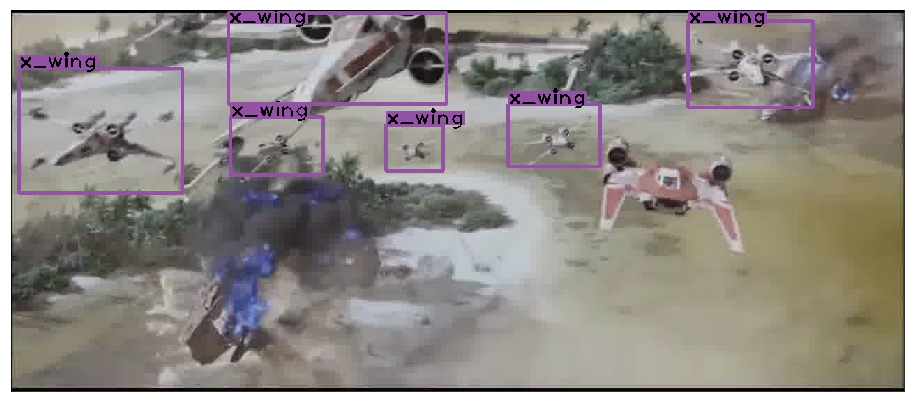

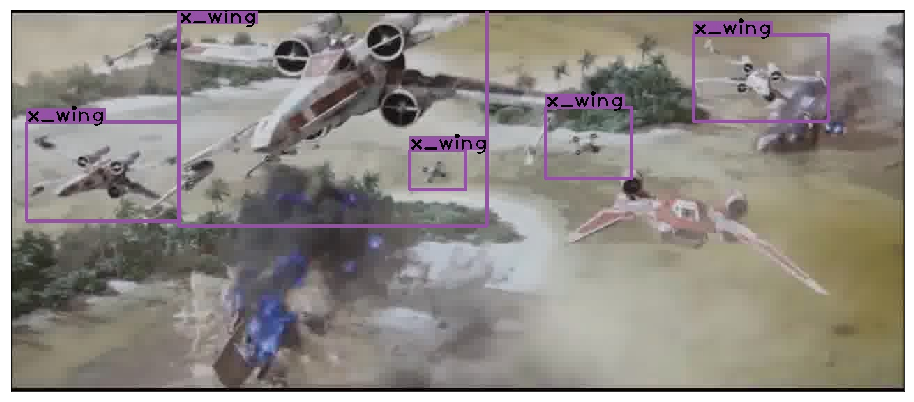

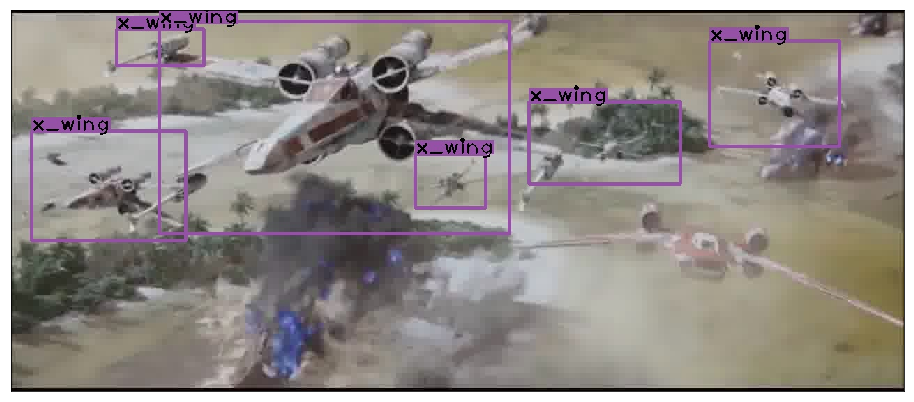

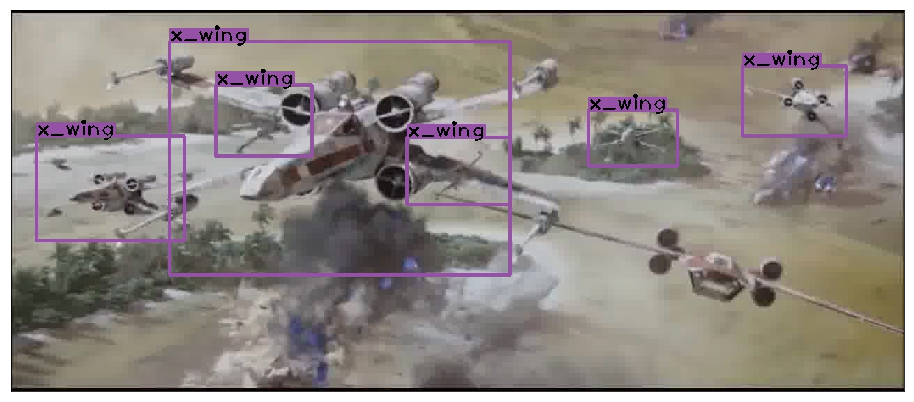

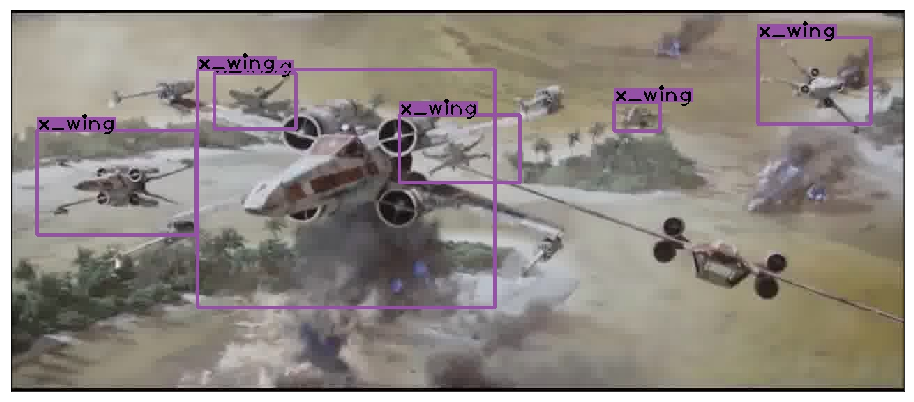

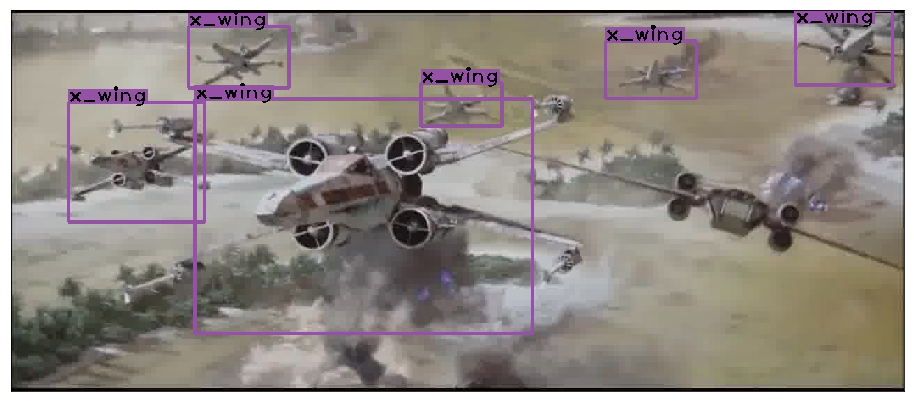

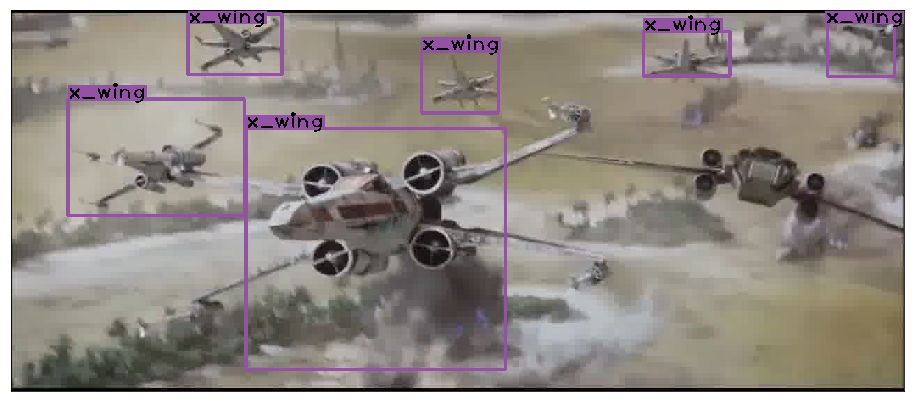

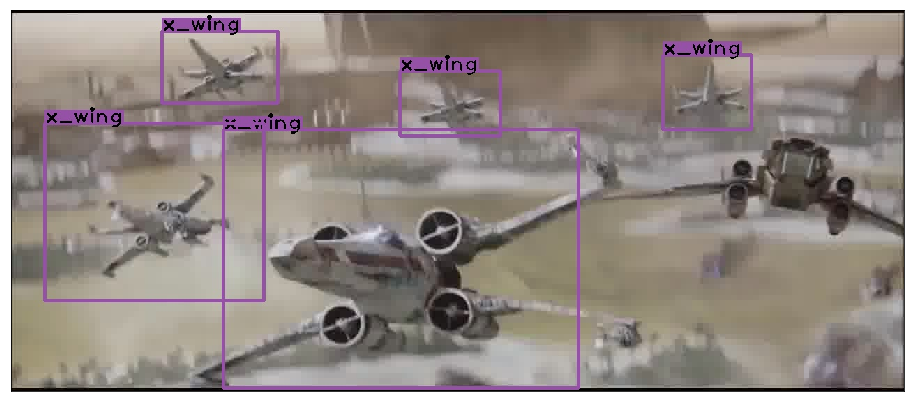

In [30]:
read_detections(output_img_dir, 0, 8)